In [1]:
using DataFrames, Random, Statistics
using Plots

x = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55]
x = float.(x)
y = 2x .+ 4
data = DataFrame(in=x, out=y)
z = data.in
lookback = 2
lookahead = 1
num_samples = length(x) - lookback - lookahead + 1
println("num samples = ", num_samples)
inputs = zeros(num_samples, lookback)
outputs = zeros(num_samples, lookahead)
for i  in 1:num_samples
    inputs[i,:] = (z[i:i+lookback-1]) 
    outputs[i,:] = z[i+lookback:i+lookback+lookahead-1]
end
println("inputs = ", inputs)
println("outputs = ", outputs)

inputs = collect((x[i:i+lookback-1]) for i in 1:num_samples)
outputs = collect((x[i+lookback:i+lookback+lookahead-1]) for i in 1:num_samples)
println("inputs = ", inputs)
println("outputs = ", outputs)

params = inputs \ outputs
estimated = inputs * params

MAError = mean(abs.(estimated - outputs))
println("Mean Absolute Error: ", MAError)

#try some non-linear stuff -> more complex, longer horizons

plot(x, label="Actual")
plot!([zeros(lookback); estimated[:,1]], label="Estimated")


num samples = 9
inputs = [0.0 1.0; 1.0 1.0; 1.0 2.0; 2.0 3.0; 3.0 5.0; 5.0 8.0; 8.0 13.0; 13.0 21.0; 21.0 34.0]
outputs = [1.0; 2.0; 3.0; 5.0; 8.0; 13.0; 21.0; 34.0; 55.0;;]
inputs = [[0.0, 1.0], [1.0, 1.0], [1.0, 2.0], [2.0, 3.0], [3.0, 5.0], [5.0, 8.0], [8.0, 13.0], [13.0, 21.0], [21.0, 34.0]]
outputs = [[1.0], [2.0], [3.0], [5.0], [8.0], [13.0], [21.0], [34.0], [55.0]]


MethodError: MethodError: no method matching zero(::Type{Vector{Float64}})

Closest candidates are:
  zero(!Matched::Union{Type{P}, P}) where P<:Dates.Period
   @ Dates /Applications/Julia-1.9.app/Contents/Resources/julia/share/julia/stdlib/v1.9/Dates/src/periods.jl:51
  zero(!Matched::FixedPointNumbers.FixedPoint)
   @ FixedPointNumbers ~/.julia/packages/FixedPointNumbers/HAGk2/src/FixedPointNumbers.jl:222
  zero(!Matched::SparseArrays.AbstractSparseArray)
   @ SparseArrays /Applications/Julia-1.9.app/Contents/Resources/julia/share/julia/stdlib/v1.9/SparseArrays/src/SparseArrays.jl:82
  ...


In [2]:
using DataFrames, Random, Statistics
using Plots

function regress(data, lookback=1, lookahead=1)
    num_samples = length(data) - lookback - lookahead + 1
    inputs = zeros(num_samples, lookback)
    outputs = zeros(num_samples, lookahead)
    for i  in 1:num_samples
        inputs[i,:] = (data[i:i+lookback-1]) 
        outputs[i,:] = data[i+lookback:i+lookback+lookahead-1]
    end

    params = inputs \ outputs
    estimated = inputs * params

    MAError = mean(abs.(estimated - outputs))
    println("Mean Absolute Error: ", MAError)
    forecast = reshape(last(data, lookback), (1, lookback)) * params
    return params
    # return estimated[:,1]
end
input_seq = [1 2 3 4 5 6 7 8 9 10]
latest = reshape(input_seq[end-1:end], (1, 2))
println(latest * regress(input_seq, 2, 3))

Mean Absolute Error: 3.2566542055671257e-15
[11.000000000000002 12.0 13.0]


In [13]:
using AirBorne.ETL.YFinance: get_interday_data
using Dates: DateTime,datetime2unix
using RollingFunctions: rolling
unix(x) = string(round(Int, datetime2unix(DateTime(x))))
data = get_interday_data(["AAPL"], unix("2023-01-01"), unix("2024-01-01"))
series = data.close
println(series)
params = regress(series, 4,2)
# estimate = reshape(series[end-3:end], (1,4)) * params
# print(estimate)
latest = reshape(series[end-3:end], (1,4))
p = plot(series, label="Actual")
forecast = []
function rollfunc(x)
    reshape(x, (1, 4)) * params 
end
forecast = rolling(rollfunc, series, 4)
first_elements = collect(Iterators.flatten([f for f in forecast[1:2:end]]))
println(first_elements)
println(length(first_elements))
println(length(series[5:end]))
# plot(series[5:end], label="Actual", title = "AAPL Forecast using Linear(4,2)")
# plot!(first_elements, label="Forecast")
# plot(p)
# plot(latest, label="Actual")
# plot!(estimate, label="Estimated")


[125.06999969482422, 126.36000061035156, 125.0199966430664, 129.6199951171875, 130.14999389648438, 130.72999572753906, 133.49000549316406, 133.41000366210938, 134.75999450683594, 135.94000244140625, 135.2100067138672, 135.27000427246094, 137.8699951171875, 141.11000061035156, 142.52999877929688, 141.86000061035156, 143.9600067138672, 145.92999267578125, 143.0, 144.2899932861328, 145.42999267578125, 150.82000732421875, 154.5, 151.72999572753906, 154.64999389648438, 151.9199981689453, 150.8699951171875, 151.00999450683594, 153.85000610351562, 153.1999969482422, 155.3300018310547, 153.7100067138672, 152.5500030517578, 148.47999572753906, 148.91000366210938, 149.39999389648438, 146.7100067138672, 147.9199981689453, 147.41000366210938, 145.30999755859375, 145.91000366210938, 151.02999877929688, 153.8300018310547, 151.60000610351562, 152.8699951171875, 150.58999633789062, 148.5, 150.47000122070312, 152.58999633789062, 152.99000549316406, 155.85000610351562, 155.0, 157.39999389648438, 159.279

Train: 200 Test: 50
Evaluating: (4, 1)
Mean Absolute Error: 1.6471796514756076
Evaluating: (4, 2)
Mean Absolute Error: 2.07802981599474
Evaluating: (4, 3)
Mean Absolute Error: 2.4167567546579614
Evaluating: (4, 4)
Mean Absolute Error: 2.7072328610313536
Evaluating: (3, 1)
Mean Absolute Error: 1.6675783204443182
Evaluating: (3, 2)
Mean Absolute Error: 2.092321341075607
Evaluating: (3, 3)
Mean Absolute Error: 2.42947128260063
Evaluating: (2, 1)
Mean Absolute Error: 1.6821229662584434
Evaluating: (2, 2)
Mean Absolute Error: 2.100784141918741
Evaluating: (1, 1)
Mean Absolute Error: 1.6791313326421542
[1.5423615481574537, 1.855805485899285, 2.2651817964369543, 2.7390191739460206, 1.5102877179226435, 1.657551215119367, 2.0580032513505158, 1.4793652018972085, 1.7731050707508593, 1.4787669256219822]
Best params: (1, 1)


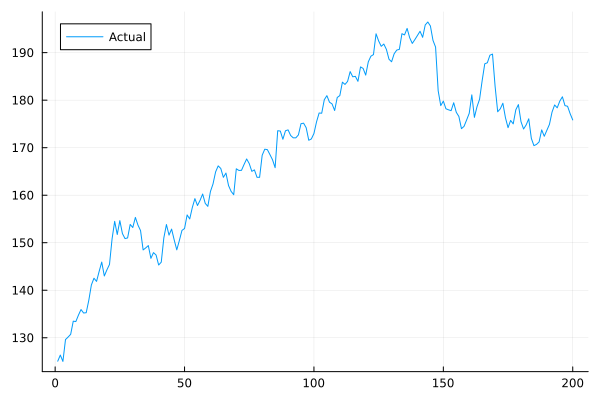

In [28]:
using RollingFunctions
using Plots
data = get_interday_data(["AAPL"], unix("2023-01-01"), unix("2024-01-01"))
train_idx = Int(length(data.close) * 0.8)
train, test = data.close[1:train_idx], data.close[train_idx+1:end]
println("Train: ", length(train), " Test: ", length(test))
paramlist = [(4, 1), (4, 2), (4, 3), (4, 4), (3, 1), (3, 2), (3, 3), (2, 1), (2, 2), (1, 1)]

function evaluate(params)
    println("Evaluating: ", params)
    multiplier = regress(train, params[1], params[2])

    function rollfunc(x)
        reshape(x, (1, params[1])) * multiplier 
    end
    p = plot(test[params[1]+1:end], label="Actual")
    expected_num = length(test) - params[1]
    forecast = rolling(rollfunc, test, params[1])
    predictions = collect(Iterators.flatten([f for f in forecast[1:params[2]:end]]))[1:expected_num]
    plot!(p, predictions, label="Forecast")
    filename = "linear_plots/plot_$(params).svg"
    savefig(p, filename)
    
    return mean(abs.(predictions - test[params[1]+1:end]))
end

errors = [evaluate(p) for p in paramlist]
println(errors)
best_params = paramlist[argmin(errors)]
println("Best params: ", best_params)
# p = plot(test, label="Actual")
# params = regress(train, best_params[1], best_params[2])


In [60]:
using DirectSearch

unix(x) = string(round(Int, datetime2unix(DateTime(x))))
data = get_interday_data(["AAPL"], unix("2023-01-01"), unix("2024-01-01"))
train_idx = Int(round(length(data.close) * 0.5))
valid_idx = Int(round(length(data.close) * 0.75))
train, validate, test = data.close[1:train_idx], data.close[train_idx+1:valid_idx], data.close[valid_idx:end]

function obj(params)
    params = round.(Int, params)
    println("Evaluating: ", params)
    multiplier = regress(train, params[1], params[2])

    function rollfunc(x)
        reshape(x, (1, params[1])) * multiplier 
    end
    p = plot(validate[params[1]+1:end], label="Actual", title = "AAPL Forecast using Linear($(params[1]),$(params[2]))")
    expected_num = length(validate) - params[1]
    forecast = rolling(rollfunc, validate, params[1])
    predictions = collect(Iterators.flatten([f for f in forecast[1:params[2]:end]]))[1:expected_num]
    plot!(p, predictions, label="Forecast")
    filename = "linear_plots/optimiser_plots/plot_$(params).svg"
    savefig(p, filename)
    
    return mean((predictions - test[params[1]+1:end]).^2)
end


p = DSProblem(2, objective=obj, initial_point=[2.0,2.0], granularity=[1,1])
valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] < (length(test) / 2))
AddExtremeConstraint(p, valcond)
Optimize!(p)

Evaluating: [2, 2]
Mean Absolute Error: 1.9652751058343496
Evaluating: [2, 1]
Mean Absolute Error: 1.6366318119224887
Evaluating: [1, 2]
Mean Absolute Error: 1.9621862477613758
Evaluating: [2, 3]
Mean Absolute Error: 2.2001849556239406
Evaluating: [3, 2]
Mean Absolute Error: 1.9570338003130583
Evaluating: [1, 1]
Mean Absolute Error: 1.6333141145343781
Evaluating: [1, 3]
Mean Absolute Error: 2.205177338820066
Evaluating: [5, 3]
Mean Absolute Error: 2.0708400411372083
Evaluating: [5, 1]
Mean Absolute Error: 1.6107765437676322
Evaluating: [8, 5]
Mean Absolute Error: 2.3167073930414848
Evaluating: [10, 2]
Mean Absolute Error: 1.801631237441644
Evaluating: [18, 3]
Mean Absolute Error: 1.83328635574265
Evaluating: [11, 10]
Mean Absolute Error: 2.6549809763690986
Evaluating: [26, 13]
Mean Absolute Error: 1.7555441045759579
Evaluating: [7, 3]
Mean Absolute Error: 2.0433781267216213
Evaluating: [6, 23]
Mean Absolute Error: 3.671706929953039
Evaluating: [16, 8]
Mean Absolute Error: 2.32383016549

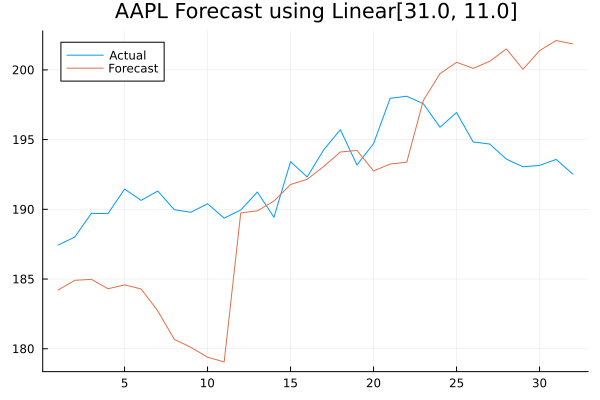

[31.0, 11.0]Mean Absolute Error: 3.482014480565658


In [61]:
print(p.x)

params = regress([train; validate], round(Int, p.x[1]), round(Int, p.x[2]))
function rollfunc(x)
    reshape(x, (1, round(Int, p.x[1]))) * params 
end
opt_plot = plot(test[round(Int, p.x[1])+1:end], label="Actual", title="AAPL Forecast using Linear$(p.x)")
expected_num = length(test) - round(Int, p.x[1])
forecast = rolling(rollfunc, test, round(Int, p.x[1]))
predictions = collect(Iterators.flatten([f for f in forecast[1:round(Int, p.x[2]):end]]))[1:expected_num]
plot!(opt_plot, predictions, label="Forecast")
savefig(opt_plot, "linear_plots/optimal_plot_$(p.x)_MAE.svg")
display(opt_plot)